In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge
from sklearn.inspection import plot_partial_dependence


rs=100

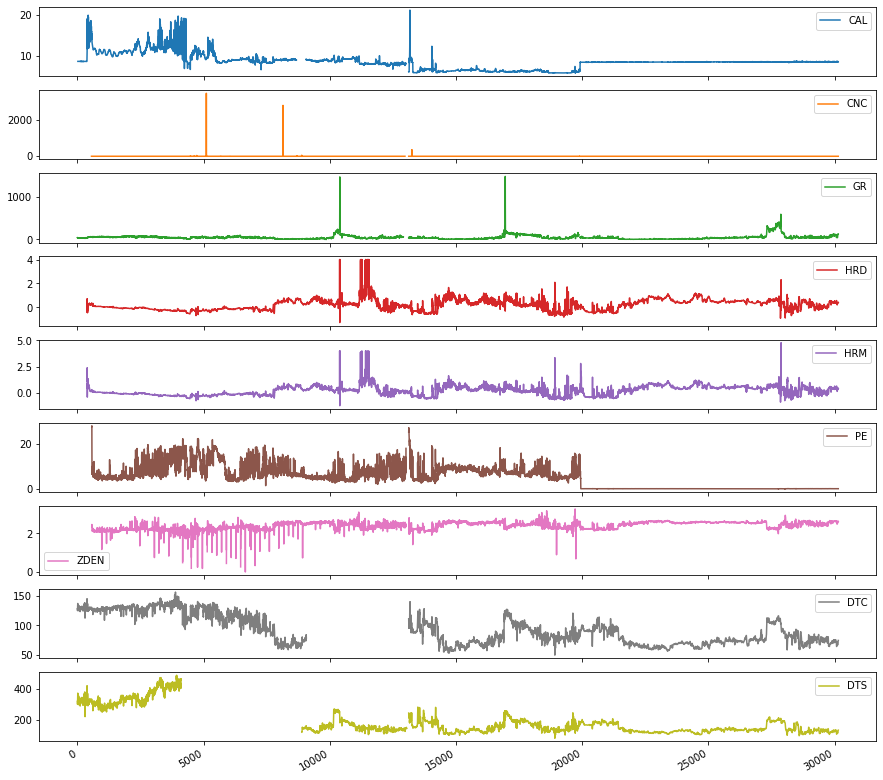

In [2]:
df1 = pd.read_csv('train.csv')
df1.replace(['-999', -999], np.nan, inplace=True)

I=df1<=0
df1[I]=np.nan

df1['HRM']=np.log10(df1['HRM'])
df1['HRD']=np.log10(df1['HRD'])
trgts=['DTC','DTS']

df1.plot(subplots=True,figsize=(15,15))
plt.show()

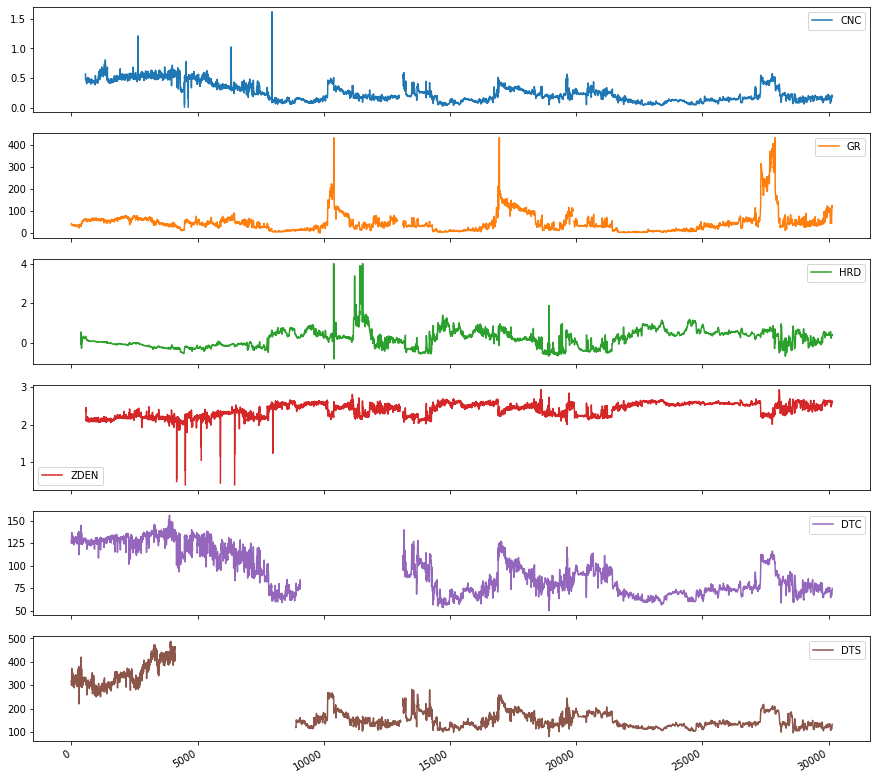

In [15]:
def _clip(df1_mod,roll=15,co=0.05):
    
    df1_med=df1_mod.rolling(roll,center=True).median()
    diff=(df1_mod-df1_med)/df1_med
    for name in diff.columns:
        I=np.abs(diff[name])>co
        df1_mod.loc[I,name]=df1_med.loc[I,name]
        
    return df1_mod

def _clip2(df,mult=5):
    
    col=df.columns
    for name in col:
        temp = df[name].copy()
        desc = temp.describe()
        Q3 = temp.quantile(0.9)
        Q1 = temp.quantile(0.1)
        IQR = Q3 - Q1
        I = temp < (Q1 - mult * IQR)
        df.loc[I,name] = (Q1 - mult * IQR)
        I = temp > (Q3 + mult * IQR)
        df.loc[I,name] = (Q3 + mult * IQR)
        
    return df


roll=9
co=.01
mult=4
drop=['CAL','PE','HRM']

df1_mod = df1.drop(columns=drop)
df1_mod = _clip2(df1_mod,mult=mult)

targets = df1_mod[trgts]
df1_mod.drop(columns=trgts,inplace=True)

df1_mod = _clip(df1_mod,roll=roll,co=co)   
feats = df1_mod.columns.tolist()
df1_mod[trgts] = targets
# imp = IterativeImputer(max_iter=100, random_state=rs, estimator=None)
# df1_mod = pd.DataFrame(imp.fit_transform(df1_mod.to_numpy()),index=df1_mod.index,columns=df1_mod.columns)

df1_mod.plot(subplots=True,figsize=(15,15))
plt.show()

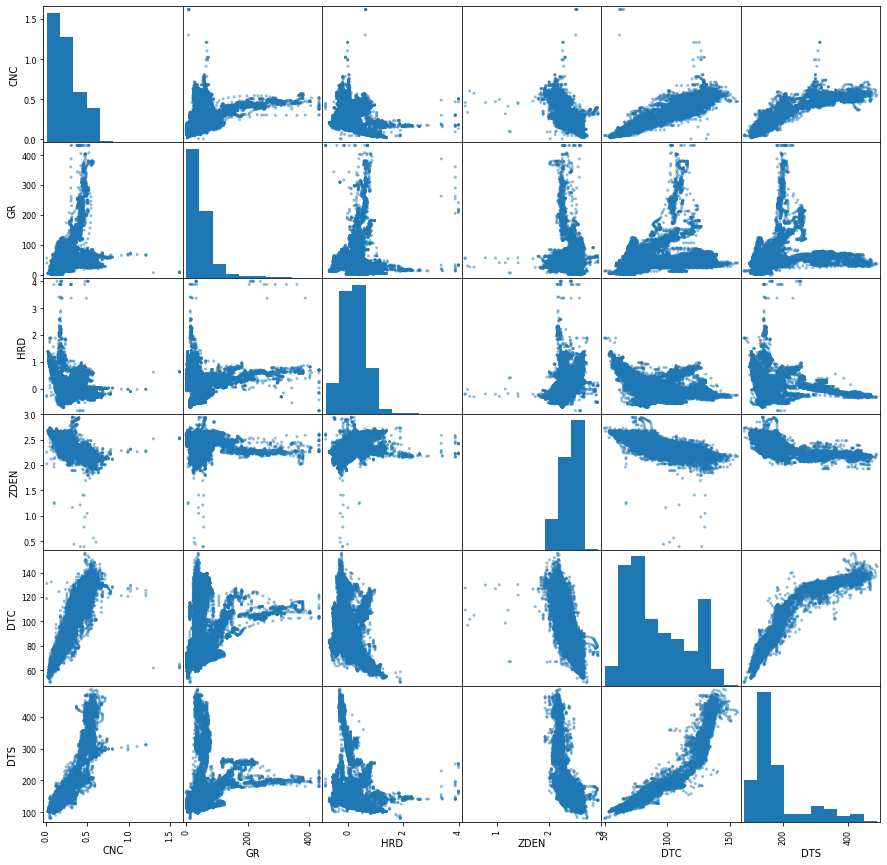

In [16]:
pd.plotting.scatter_matrix(df1_mod,figsize=(15,15))
plt.show()

In [17]:
# seperate the features and targets
df1_clean=df1_mod.dropna()
df1_data = df1_clean.to_numpy()
y_trainwell1 = df1_data[:,-2:]
x_trainwell1 = df1_data[:,:-2]

# standize the matrix for training data
steps = [('RS1',RobustScaler())]

# scaler = StandardScaler()
prep = Pipeline(steps)
# dtc_scale = RobustScaler()

x_trainwell1 = prep.fit_transform(x_trainwell1)
# y_dtc = y_trainwell1[:,0]
# y_dtc = y_dtc[:,np.newaxis]
# dtc_scale.fit(y_dtc)

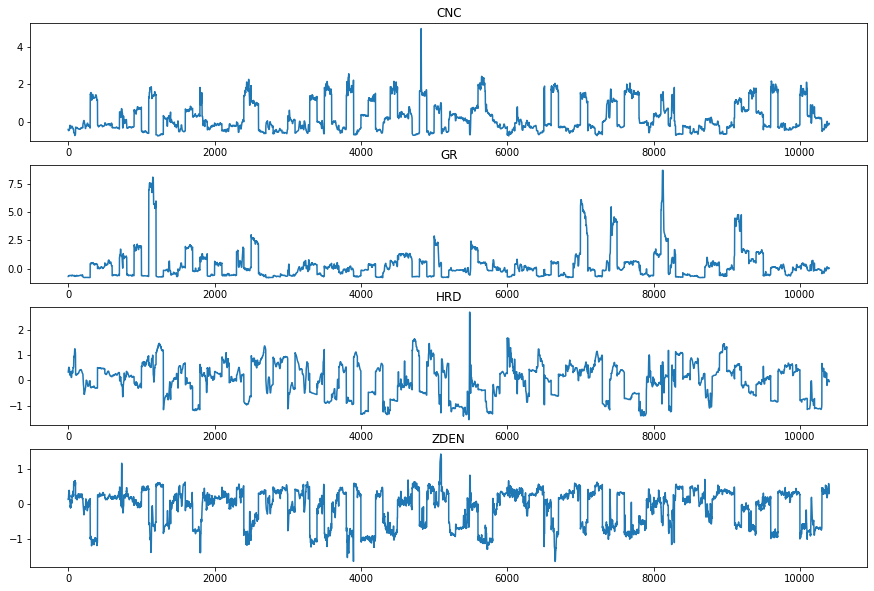

In [18]:
np.random.seed(rs)

def _create_test_set(x_train, y_train, test_size=.25, seg_len=100):
    l=x_train.shape[0]
    cpy=l
    x_test=[]
    y_test=[]
    x=x_train
    y=y_train
    while (cpy/l) >= (1-test_size):
        I=np.random.randint(0,cpy-seg_len)
        x_test.append(x[I:I+seg_len,:])
        y_test.append(y[I:I+seg_len,:])
        x=np.delete(x,range(I,I+seg_len,1),0)
        y=np.delete(y,range(I,I+seg_len,1),0)
        cpy=x.shape[0]
        
    return x,y,np.vstack(x_test), np.vstack(y_test)

x_train,y_train,x_test,y_test = _create_test_set(x_trainwell1,y_trainwell1,
                                                 test_size=0.5,
                                                 seg_len=100)

ncol=x_test.shape[1]
fig=plt.figure(figsize=(15,10))
for i in range(1,ncol+1):
    plt.subplot(ncol,1,i)
    plt.plot(x_test[:,i-1])
    plt.title(feats[i-1])

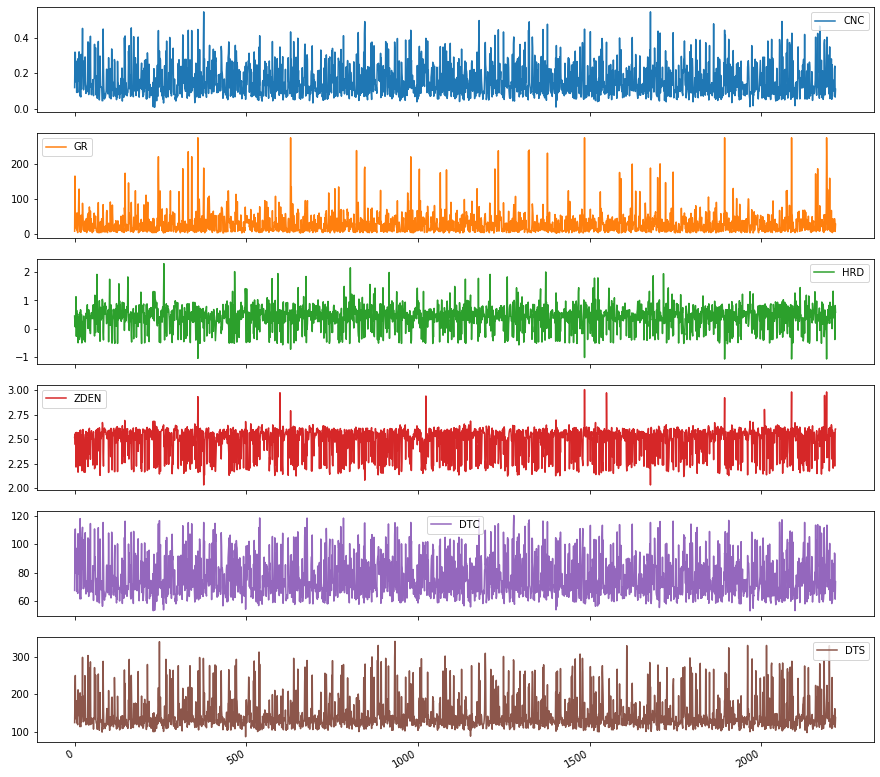

In [19]:
val20 = pd.read_csv('real_result_20perc.csv')

I=val20<=0
val20[I]=1e-3

val20['HRM']=np.log10(val20['HRM'])
val20['HRD']=np.log10(val20['HRD'])
val20.drop(columns=drop,inplace=True)

val20 = _clip2(val20,mult=mult)
val20.plot(subplots=True,figsize=(15,15))
plt.show()

In [20]:
# seperate the features and targets
val20_data = val20.to_numpy()
y_val = val20_data[:,-2:]
x_val = val20_data[:,:-2]

# standize the matrix for training data
x_val = prep.transform(x_val)

# ncol=y_val.shape[1]
# fig=plt.figure(figsize=(15,10))
# for i in range(1,ncol+1):
#     plt.subplot(ncol,1,i)
#     plt.plot(y_val[:,i-1])

In [21]:
def _error(y_true,y_pred):
    
    e1 = (y_true[0]-y_pred[0])**2
    e2 = (y_true[1]-y_pred[1])**2
    return np.sqrt(0.5*np.mean(e1 + e2))

def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    print('Root Mean Square Error DTC:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real[:,0], y_predict[:,0]))))
    print('Root Mean Square Error DTS:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real[:,1], y_predict[:,1]))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.gca().set_aspect('equal')
    xlim = plt.gca().get_xlim()
    plt.ylim(xlim)
    plt.plot(xlim,xlim,'k--')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.gca().set_aspect('equal')
    xlim = plt.gca().get_xlim()
    plt.ylim(xlim)
    plt.plot(xlim,xlim,'k--')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [22]:
def _optimize_model(x_train,y_train,x_test,y_test,estimator,params,niter=10):
    
    result=pd.DataFrame()
    for i in range(niter):
        newP = params[i]
        model = estimator
        model.set_params(**newP)
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        test_error = np.sqrt(mean_squared_error(y_test,pred))
        dts_error = np.sqrt(mean_squared_error(y_test[1],pred[1]))
        dtc_error = np.sqrt(mean_squared_error(y_test[0],pred[0]))
        temp = pd.DataFrame({'Model':[model],'Test_Error':[test_error],
                             'DTS_Error':[dts_error],
                             'DTC_Error':[dtc_error],
                             'Params':[newP]})
        result = pd.concat((result,temp),axis=0,ignore_index=True)
        del model
        
    result_sorted = result.sort_values('Test_Error',ignore_index=True)
    return result_sorted

In [23]:
np.random.seed(rs)
niter=20

params = {'estimator__C':10**np.random.uniform(0,1.7,niter)}
params = pd.DataFrame(params).to_dict('records')

SVR_ = MultiOutputRegressor(SVR('rbf'))

SVR_result = _optimize_model(x_train,y_train,x_val,y_val,SVR_,params,niter)
SVR_result.head(8)

,Model,Test_Error,DTS_Error,DTC_Error,Params
0,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.122546,10.134370,2.323064,{'estimator__C': 1.6094130011916201}
1,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.126255,10.275455,2.318266,{'estimator__C': 1.7076592009342482}
2,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.127393,10.697763,2.293785,{'estimator__C': 1.9601970065692769}
3,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.127511,9.960578,2.341556,{'estimator__C': 1.528412967769496}
4,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.132068,10.717874,2.273131,{'estimator__C': 2.06565587831329}
5,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.137105,10.905130,2.238234,{'estimator__C': 2.3631197913567354}
6,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.138439,10.770695,2.255450,{'estimator__C': 2.2680029107782143}
7,MultiOutputRegressor(estimator=SVR(C=2.9236499...,15.155887,11.596159,2.178789,{'estimator__C': 2.9236499288444446}


Root Mean Square Error is: 12.54937
Root Mean Square Error DTC: 3.98887
Root Mean Square Error DTS: 17.29342


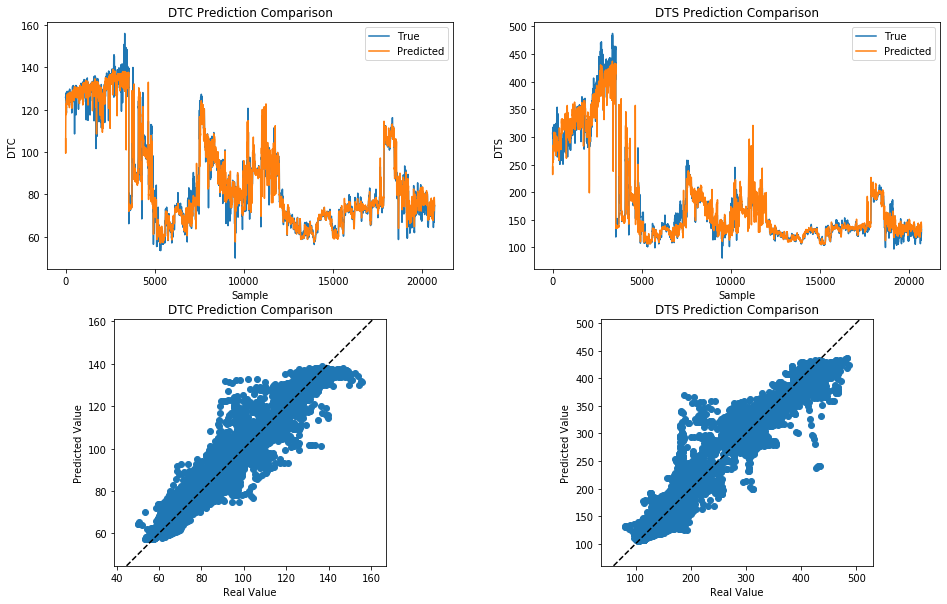

Root Mean Square Error is: 14.87598
Root Mean Square Error DTC: 4.48902
Root Mean Square Error DTS: 20.55330


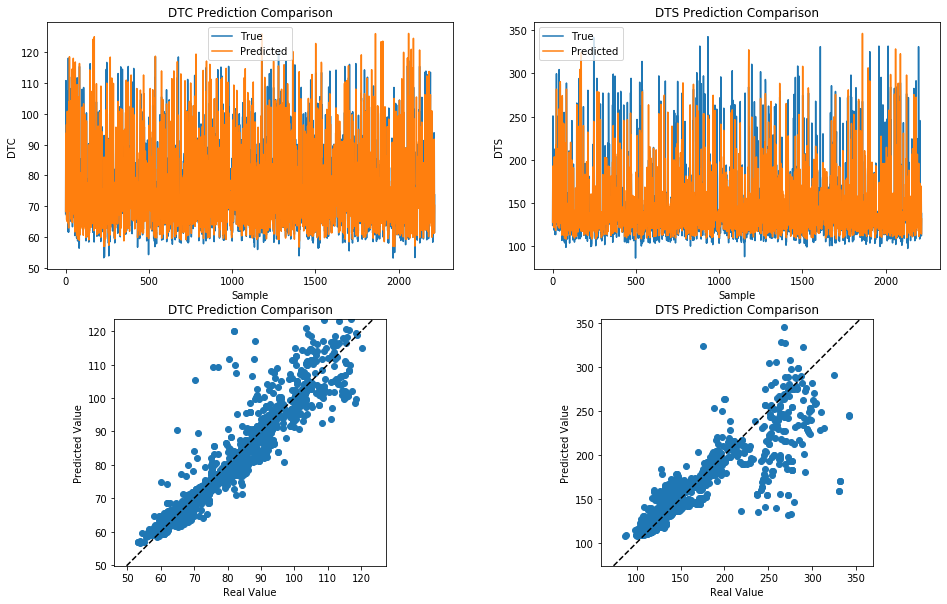

In [24]:
svr = MultiOutputRegressor(SVR('rbf'))
svr.set_params(**SVR_result['Params'].iloc[0])
svr.fit(x_trainwell1,y_trainwell1)

result_plot(svr.predict(x_trainwell1),y_trainwell1)
result_plot(svr.predict(x_val),y_val)

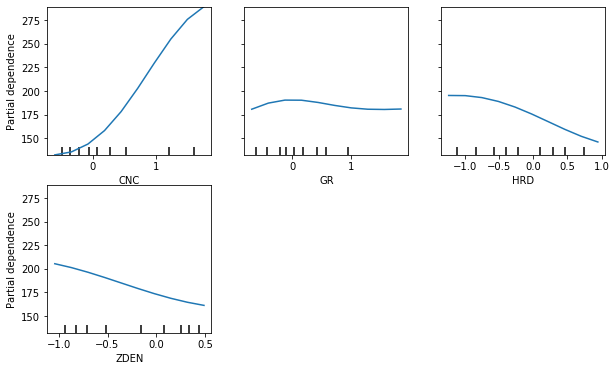

In [25]:
feat = np.arange(len(feats)).tolist()
plot_partial_dependence(svr,x_train,feat,
                        feature_names=feats,target=1,
                        grid_resolution=10,n_jobs=-1)
plt.gcf().set_size_inches((10,6))
plt.show()

(11088, 4)


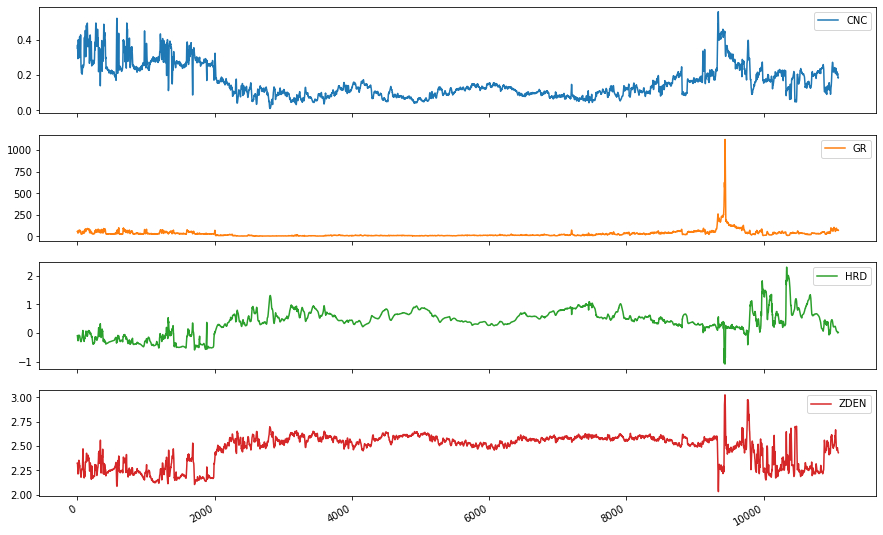

In [26]:
# load test data from well 2
df_well2 = pd.read_csv('test.csv')
df_well2['HRM']=np.log10(df_well2['HRM'])
df_well2['HRD']=np.log10(df_well2['HRD'])
df_well2.drop(columns=drop,inplace=True)
print(df_well2.shape)

df_well2.plot(subplots=True,figsize=(15,10))
plt.show()

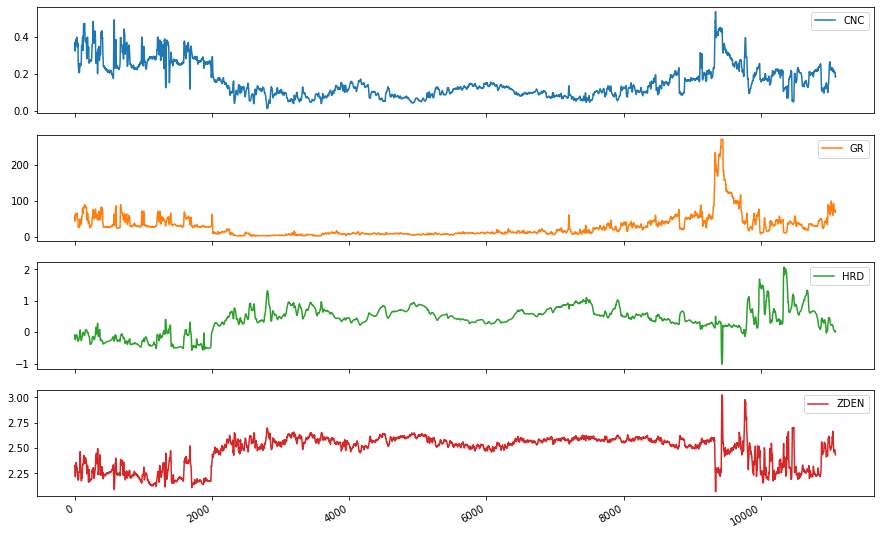

In [27]:
df_well2_mod = _clip2(df_well2,mult=mult)
df_well2_mod = _clip(df_well2_mod,roll=roll,co=co)   
df_well2_mod.plot(subplots=True,figsize=(15,10))
plt.show()

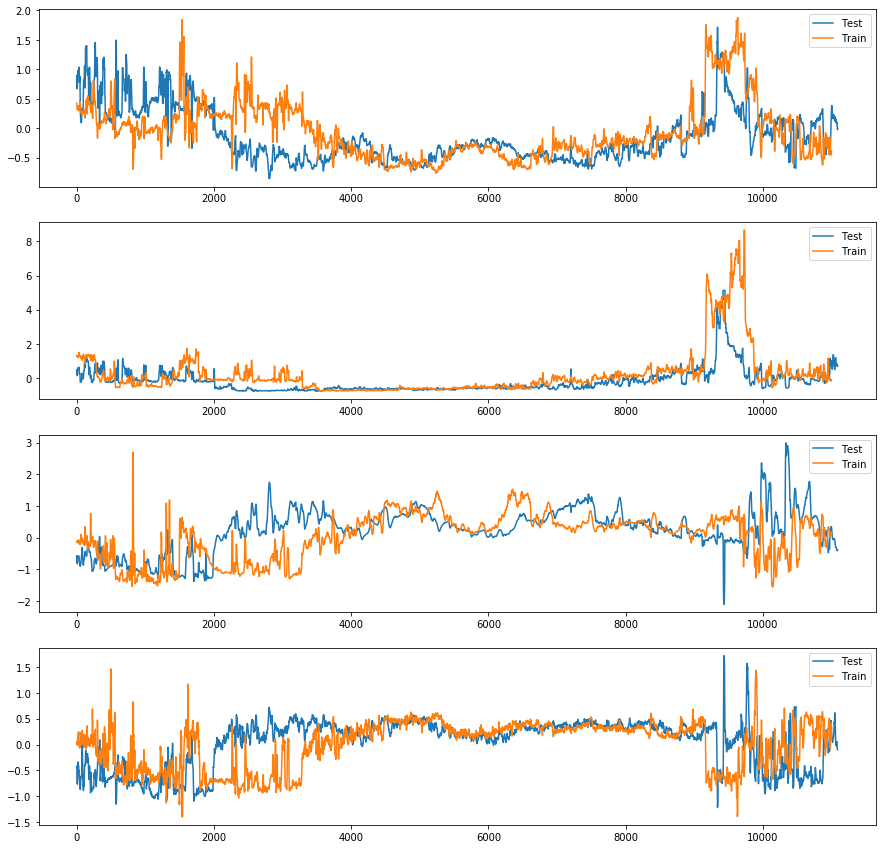

In [28]:
well2_data = df_well2_mod.to_numpy()
well2_data = prep.transform(well2_data)

ncol=well2_data.shape[1]
fig=plt.figure(figsize=(15,15))
for i in range(1,ncol+1):
    plt.subplot(ncol,1,i)
    plt.plot(well2_data[:,i-1],label='Test')
    plt.plot(x_trainwell1[-12000:-1000,i-1],label='Train')
    plt.legend()

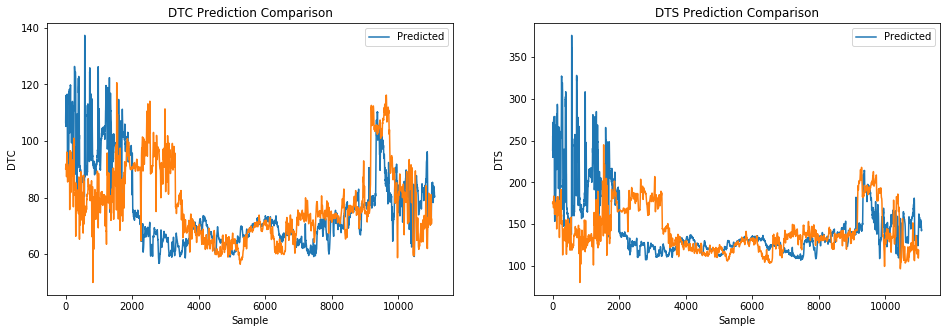

(11088, 2)


,DTC,DTS
0,106.500109,238.579998
1,108.436876,247.666857
2,110.107614,255.508042
3,110.205392,255.539121
4,108.250114,245.493683


In [29]:
# well2_predict = _Vote(Model1,Model2,well2_data,w1,w2)
well2_predict = svr.predict(well2_data)

# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.plot(y_trainwell1[-12000:-1000,0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.plot(y_trainwell1[-12000:-1000,1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
print(output_result.shape)
output_result.head()

In [30]:
output_result[['DTC','DTS']].to_csv(path_or_buf='./StuckAtHome_submission_02a.csv', index=False)